[Markdown cheatsheet](https://daringfireball.net/projects/markdown/syntax)

# Analysis of Discourse Macrostructure in Schizophrenia: a Corpus Study
__Ryazanskaya Galina,
    Center for Language and Brain, HSE__

## my plans

[my secrert plan for this project and more](https://docs.google.com/document/d/1GATeTSyHrhbg5M_5hWci77V3ys_P0gS8KzdyQY1JNLE/edit)

The corpus of Russian internet language I am using is called RuWac. Here I have a link: 
[RuWac about](https://bitbucket.org/kostialopuhin/russe)

I also provide a link for direct download of the corpus archive (9GB): 
[RuWac](http://corpus.leeds.ac.uk/tools/ru/ruwac-parsed.out.xz)

### let us install everything

In [ ]:
!pip install numpy

In [ ]:
!pip install progressbar2

In [ ]:
!pip install gensim

__let us also download the archived corpus__<br>
don't do it, it's heavy

In [ ]:
!wget "http://corpus.leeds.ac.uk/tools/ru/ruwac-parsed.out.xz"

### let us now do the things we will repeat many times as we work

In [268]:
!git commit modeling_schizo.ipynb -m ""

[master 92914b5] grid search
 1 file changed, 474 insertions(+), 74 deletions(-)


The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.


In [1]:
import gensim
import logging
import lzma
import os
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from datetime import datetime
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from progressbar import progressbar
from sklearn import svm
from sklearn.exceptions import UndefinedMetricWarning
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut, cross_val_score, GridSearchCV, train_test_split
from string import punctuation as punct
from string import ascii_letters as latin
punct += '»«'

warnings.simplefilter('ignore', UndefinedMetricWarning)

corpus_archive_filename = 'ruwac-parsed.out.xz'
corpus_filename = 'corpus.txt'
premodel_filename = 'small.model'
vocabulary_filename = 'freq.txt'
model_filename = 'full.model'
sample_directory = 'sample'
manual_filename = 'manual_metrics.csv'
df_filename = 'df.csv'

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
model = gensim.models.Word2Vec.load(model_filename)
patient_df = pd.read_csv(manual_filename)

## let us take the corpus out of the archive

__let us also take lemmas and make out of them a file with \n-separated sentences, including only sentences not containing latin symbols__

In [ ]:
with lzma.open(corpus_archive_filename, mode='rt', encoding='utf-8') as f:
    with open(corpus_filename, mode='w', encoding='utf-8') as t:
        current = []
        for line_number, line in enumerate(f):
            if line_number % 10000000 == 0:
                print(line_number, datetime.now().time(), file=open('archive_log.txt', 'a', encoding='utf-8'))
            l = line.split('\t')
            if len(l) == 7:
                lemm = l[3]
                sent = l[1]
                if sent == 'SENT':
                    if set(latin).intersection(set(''.join(current))) == set():
                        current.append('\n')
                        print(' '.join(current), file=t, end='')
                    current = []
                elif lemm not in punct:
                    current.append(lemm)

__here are some examples for me__

[word2vec source link](https://radimrehurek.com/gensim/models/word2vec.html)

[word2vec tutorial](https://rare-technologies.com/word2vec-tutorial/)

[my previous work on w2v](https://github.com/flying-bear/HSE_programming/blob/master/HSE_programming_2/hws/hw_word2vec/HW_word2vec.ipynb)

## let us create a subset of corpus for testing before training on the big corpus

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [6]:
sentences = []
with open(corpus_filename, 'r', encoding='utf-8') as file:
            for line in file:
                if len(sentences) < 1000:
                    sentences.append(line.split())
                else:
                    break

In [7]:
premodel = gensim.models.Word2Vec(sentences, min_count = 1, epochs=1)

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "
2018-12-01 20:08:20,475 : INFO : collecting all words and their counts
2018-12-01 20:08:20,483 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-12-01 20:08:20,499 : INFO : collected 3542 word types from a corpus of 12137 raw words and 1000 sentences
2018-12-01 20:08:20,503 : INFO : Loading a fresh vocabulary
2018-12-01 20:08:20,539 : INFO : effective_min_count=1 retains 3542 unique words (100% of original 3542, drops 0)
2018-12-01 20:08:20,539 : INFO : effective_min_count=1 leaves 12137 word corpus (100% of original 12137, drops 0)
2018-12-01 20:08:20,591 : INFO : deleting the raw counts dictionary of 3542 items
2018-12-01 20:08:20,599 : INFO : sample=0.001 downsamples 43 most-comm

__let us check and save the test model__

In [21]:
premodel.wv['я']

numpy.ndarray

In [13]:
list(premodel.wv.vocab.items())[:10]

[('это', <gensim.models.keyedvectors.Vocab at 0xf4627b5358>),
 ('тип', <gensim.models.keyedvectors.Vocab at 0xf4627b53c8>),
 ('девушка', <gensim.models.keyedvectors.Vocab at 0xf4627b5588>),
 ('в', <gensim.models.keyedvectors.Vocab at 0xf4627b55c0>),
 ('один', <gensim.models.keyedvectors.Vocab at 0xf4627b56a0>),
 ('день', <gensim.models.keyedvectors.Vocab at 0xf4627b56d8>),
 ('отмечать', <gensim.models.keyedvectors.Vocab at 0xf4627b5710>),
 ('что', <gensim.models.keyedvectors.Vocab at 0xf4627b5748>),
 ('на', <gensim.models.keyedvectors.Vocab at 0xf4627b5780>),
 ('себя', <gensim.models.keyedvectors.Vocab at 0xf4627b57b8>)]

In [5]:
premodel.similarity('найти', 'второй')

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.036809895

In [9]:
premodel.most_similar(positive=['банк'], negative=[], topn=10)

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('тотальнее', 0.35982415080070496),
 ('управляемый', 0.3162972331047058),
 ('решить', 0.3074740767478943),
 ('живой', 0.29716986417770386),
 ('баррикада', 0.29420873522758484),
 ('владелец', 0.29158836603164673),
 ('верить', 0.29105377197265625),
 ('маскировка', 0.29051047563552856),
 ('разгар', 0.28887930512428284),
 ('возможно', 0.28510481119155884)]

__let us save it__

In [11]:
premodel.save(premodel_filename)

2018-12-01 20:11:08,616 : INFO : saving Word2Vec object under word2vec.model, separately None
2018-12-01 20:11:08,632 : INFO : not storing attribute vectors_norm
2018-12-01 20:11:08,640 : INFO : not storing attribute cum_table
2018-12-01 20:11:08,824 : INFO : saved word2vec.model


__now we can load it__

In [20]:
premodel = gensim.models.Word2Vec.load(premodel_filename)

## let us run the training on the full corpust text now

### let us generate a vocabulary

In [2]:
def get_vocabulary(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            for word in line.split():
                yield word

In [22]:
def get_sentences(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            yield line.split()

In [11]:
word_freq = Counter(progressbar(get_vocabulary(corpus_filename)))

| |                    #                     | 1296566294 Elapsed Time: 0:48:07


__let us save it__

In [15]:
with open(vocabulary_filename, 'w', encoding='utf-8') as file:
    file.writelines(word_freq)

__now we can just read the vocabulary__

In [ ]:
with open(vocabulary_filename, 'r', encoding='utf-8') as file:
    word_freq = file.readlines()

### let us give the model the vocabulary

In [17]:
model = gensim.models.Word2Vec(sg=1, min_count=10, workers=1, size=300)

In [18]:
logging.basicConfig(filename='vocabulary.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [19]:
model.build_vocab_from_freq(word_freq)

__let us save it__

In [20]:
model.save(model_filename)

### let us train the model

In [26]:
logging.basicConfig(filename='training.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [27]:
model.train(get_sentences(corpus_filename), epochs=1, total_examples=len(word_freq))

(1100046103, 1296566295)

__let us save it__

In [29]:
model.save(model_filename)

In [31]:
model.most_similar(positive=['банк'], negative=[], topn=10)

/home/gryazanskaya/modeling_schizo/env/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/home/gryazanskaya/modeling_schizo/env/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('сбербанк', 0.8356039524078369),
 ('банковский', 0.8246872425079346),
 ('кредитный', 0.8222591876983643),
 ('ипотечный', 0.8164801597595215),
 ('банка', 0.804668664932251),
 ('втб', 0.7961848974227905),
 ('сберегательный', 0.7937512397766113),
 ('цб', 0.790773332118988),
 ('кредит', 0.7881439924240112),
 ('эмитент', 0.7846423387527466)]

__now we can load it__

In [48]:
model = gensim.models.Word2Vec.load(model_filename)

## let us prepare the texts from the sample

__the sample consists of__ 

+ 9 outpatients diagnosed with schizophrenia
+ 10 controls from Russian Clinical Pear Stories Corpus (CliPS)

the original CliPS corpus contains pear film [Chafe, Freedle, & Bois, 1980](http://www.lattice.cnrs.fr/IMG/pdf/DuBois_1980_Beyond_Definiteness_L.pdf) retellings from people with aphasia, traumatic brain injuries, as well as healthy controls

the files contain already lemmatized texts with \n separated sentences (discourse units)

In [7]:
sample = {'control': {}, 'schizo': {}}

for filename in os.listdir(sample_directory):
    file_path = sample_directory + '/' + filename
    name = filename.strip('.txt')
    with open(file_path, 'r', encoding='utf-8') as file:
        raw_sent = file.readlines()
    sent = []
    for raw in raw_sent:
        sent.append(raw.strip().split())
    if 'H' in filename:
        sample['control'][name] = sent
    elif 'S' in filename:
        sample['schizo'][name] = sent

let us ensure that it works

In [8]:
sample['control']['HP-03']

[['вот', 'нет', 'текст'],
 ['это', 'так', 'задумать', 'да'],
 ['ну', 'я', 'думать', 'что', 'это', 'такой', 'такой', 'сюжетик', 'фильм'],
 ['значит',
  'это',
  'где',
  'то',
  'южный',
  'страна',
  'может',
  'мексика',
  'может',
  'что'],
 ['человек', 'там'],
 ['дело',
  'в',
  'то',
  'что',
  'это',
  'не',
  'на',
  'свой',
  'участок',
  'видно',
  'человек',
  'собирать',
  'урожай',
  'груша'],
 ['большой',
  'груша',
  'стоять',
  'дикий',
  'ну',
  'большой',
  'такой',
  'полноценный',
  'груша',
  'не',
  'дичка',
  'какой',
  'то',
  'там',
  'вот'],
 ['и', 'в', 'общем', 'должен', 'быть', 'три', 'корзина', 'нагрузить', 'вот'],
 ['ну',
  'в',
  'один',
  'момент',
  'он',
  'значит',
  'сделать',
  'с',
  'один',
  'груша',
  'видно',
  'как',
  'благодарность',
  'этот',
  'груша',
  'что',
  'они',
  'он',
  'может',
  'бесплатно',
  'доставаться',
  'он',
  'сделать',
  'ритуал'],
 ['вытереть', 'один', 'груша', 'свой', 'шейный', 'платок', 'вот'],
 ['потом', 'подъехать'

let us create a pandas dict for our metrics

In [3]:
patient_df = pd.read_csv(manual_filename)

In [5]:
patient_df = pd.read_csv(df_filename).drop('Unnamed: 0', axis=1)

In [42]:
for col in patient_df:
    if col not in ['ID', 'group', 'diagnosis', 'man_compl_viol', 'man_compl_viol_per_utt']:
        patient_df[col] = pd.Series([1/x for x in patient_df[col]], index = patient_df.index)

In [4]:
patient_df

,ID,group,diagnosis,num_utt,man_gcoh,man_av_gcoh,man_compl_viol,man_compl_viol_per_utt,man_lcoh,man_av_lcoh
0,SP-01,schizo,1,26,112,4.307692,0,0.000000,97,3.730769
1,SP-02,schizo,1,17,67,3.941176,3,0.176471,61,3.588235
2,SP-03,schizo,1,20,84,4.200000,2,0.100000,69,3.450000
3,SP-04,schizo,1,19,83,4.368421,1,0.052632,70,3.684211
4,SP-05,schizo,1,9,27,3.000000,4,0.444444,22,2.444444
5,SP-06,schizo,1,37,179,4.837838,0,0.000000,146,3.945946
6,SP-07,schizo,1,50,206,4.120000,1,0.020000,156,3.120000
7,SP-08,schizo,1,31,139,4.483871,0,0.000000,113,3.645161
8,SP-09,schizo,1,35,127,3.628571,2,0.057143,119,3.400000
9,HP-03,control,0,35,135,3.857143,0,0.000000,128,3.657143


__let us save the df__

In [25]:
patient_df.to_csv(path_or_buf='df.csv', sep=',')

## TF-IDF
let us create a tf-idf model <br>
we will use words from sample as its dictionary <br>
we will first 100000 sentences of the corpus as the training text <br>

we will later use idf for weighting the vectors

__let us create the dictionary__

In [137]:
dct = Dictionary()
for group in sample:
    for patient in sample[group]:
        dct.add_documents(sample[group][patient])

__we will use "bag of words" approach to train the tf-idf model__

In [115]:
dct.doc2bow(['я','идти','корзина', 'я'])

[(13, 2), (42, 1), (131, 1)]

__let us train the model__

In [138]:
corpus = []
with open(corpus_filename, 'r', encoding='utf-8') as file:
    for n, line in enumerate(file):
        if n > 100000:
            break
        corpus.append(dct.doc2bow(line.split()))

In [143]:
for group in sample:
    for patient in sample[group]:
        for clause in sample[group][patient]:
            corpus.append(dct.doc2bow(clause))

In [ ]:
tf_idf = TfidfModel(corpus)

let us see how a vector from the model looks

In [148]:
vector = tf_idf[corpus[10]]
vector

[(27, 0.41397533542733106),
 (41, 0.257813199691383),
 (65, 0.570971179937033),
 (178, 0.6604155414616106)]

__let us create a dictionary of idfs of the words from our sample__

In [ ]:
idfs = {}
for key in dct:
    idfs[dct[key]] = tf_idf.idfs[key]

let us see how it looks now

In [162]:
list(idfs.items())[25:35]

[('груша', 9.641392345549054),
 ('дело', 6.149030451809454),
 ('на', 2.834753223576036),
 ('не', 2.3682998231240004),
 ('свой', 4.642824301042186),
 ('собирать', 9.45880093227058),
 ('урожай', 12.033709768327814),
 ('участок', 10.53120942779863),
 ('большой', 6.784201219064748),
 ('дикий', 10.53120942779863)]

__let us save the idf dictionary__

In [166]:
with open('idfs.txt', 'w', encoding='utf-8') as file:
    for key in idfs:
        file.write(key+' '+str(idfs[key])+'\n')

__now we can load it__

In [9]:
idfs = {}
with open('idfs.txt', 'r', encoding='utf-8') as file:
    for line in file:
        key, str_val = line.split()
        idfs[key] = float(str_val)

<h2>let us finally apply the metrics</h2>

see [Glosser & Desser, 1990](https://doi.org/10.1016/0093-934X(91)90117-J)

- __Tangentiality__ (see [Elvevåg et al 2017](https://academic.oup.com/schizophreniabulletin/article/43/3/509/3574458))
- __Local coherence__ (see [Wright, Capilouto, & Koutsoftas, 2013](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3799984/))
- __Global coherence__ (see [Coelho & Flewellyn, 2003](https://doi.org/10.1080/729255216))
- __Violations of completeness__ (see [Christiansen, 1995](https://doi.org/10.1006/brln.1995.1062))

__first let us calculate a idf-weighted average of some vectors <br>
let us also find which vectors are most similar to the result__

In [10]:
words = ['он','нести', 'корзина','груша']
vectors = [model.wv[word] for word in words]
weights = [idfs[word] for word in words]
model.wv.similar_by_vector(np.average(vectors, weights=weights, axis=0))

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('корзина', 0.8727326989173889),
 ('жоп', 0.8549065589904785),
 ('заместо', 0.8523340225219727),
 ('такса', 0.8501752614974976),
 ('окленда', 0.8486794829368591),
 ('матрешка', 0.847322940826416),
 ('чернолецкая', 0.8453708291053772),
 ('конвертик', 0.8453339338302612),
 ('пирожковый', 0.8448746204376221),
 ('складировать', 0.8448312282562256)]

In [80]:
v1 = model.wv['мания']
v2 = model.wv['депрессия']
v3 = model.wv['психоз']

model.wv.similar_by_vector(np.mean([v1,v2,v3], axis=0))

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('депрессия', 0.932645857334137),
 ('психоз', 0.9326068162918091),
 ('паранойя', 0.9035854339599609),
 ('мания', 0.8933574557304382),
 ('подавленность', 0.8921741247177124),
 ('амнезия', 0.8852319717407227),
 ('помешательство', 0.8844729065895081),
 ('апатия', 0.8835541605949402),
 ('навязчивость', 0.8810394406318665),
 ('пессимизм', 0.8810359239578247)]

In [81]:
model.wv.most_similar(positive=['депрессия', 'мания', 'психоз'])

[('паранойя', 0.9100965261459351),
 ('помешательство', 0.8941826820373535),
 ('подавленность', 0.8941128849983215),
 ('амнезия', 0.8906843662261963),
 ('пессимизм', 0.8890512585639954),
 ('навязчивость', 0.8871198892593384),
 ('забывчивость', 0.8851627707481384),
 ('шизофрения', 0.8843259215354919),
 ('припадок', 0.8841286897659302),
 ('фрустрация', 0.883934736251831)]

### let us get an idf-weighted average vector for each clause in a file

In [17]:
def get_file_clause_vectors(clauses):
    clauses_array = []
    for clause in clauses:
        clause_vect_array = []
        clause_idf_array = []
        for word in clause:
            try:
                vect = model.wv[word]
                idf = idfs[word]
            except KeyError:
                with open('words_not_found.txt', 'w', encoding='utf-8') as f:
                    f.write(word+'\n')
                continue
            if idf:
                clause_vect_array.append(vect)
                clause_idf_array.append(idf)
            else:
                continue
        if clause_idf_array:
            clause_vector = np.average(clause_vect_array, weights=clause_idf_array, axis=0)
            clauses_array.append(clause_vector)
        else:
            continue
    return clauses_array

let us test in on an example

In [18]:
file = [['я','не', 'понять'], ['он','странно'], ['не', 'быть']]
model.wv.similar_by_vector(np.average(get_file_clause_vectors(file), axis=0))

[('он', 0.937483549118042),
 ('они', 0.8934867978096008),
 ('она', 0.8883097171783447),
 ('стопроцентно', 0.8796114325523376),
 ('долгин', 0.8778481483459473),
 ('филина', 0.8763973712921143),
 ('котрый', 0.8760072588920593),
 ('плутарх', 0.8751401901245117),
 ('не', 0.8748624920845032),
 ('я', 0.874592125415802)]

here I will redifine cosine similarity because I am retarded

In [11]:
def cos_sim(v1, v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

<h3>Semi-local coherence</h3>
<ul>
    <li>cumulative semi-local coherence<br>
        a plot: <br>
        x axis: distance between the clauses (measured in clauses or words) <br>
        y axis: cosine distance between an averaged vector of the first <i>n</i> clauses and the current clause
    </li>
    <li>several graphs for varying spans (span ~8 recomended as a meaningful minimum): <br>
        x axis: distance between the spans in words <br>
        y axis: cosine distance between an averaged vector of the first span and the current span
    </li>
</ul>

In [46]:
def get_cumulative_tangentiality_array(clauses):
    clause_vectors = get_file_clause_vectors(clauses)
    cumulative_tangentiality_array = []
    for i in range(len(clause_vectors)):
        if i:
            cumulative_tangentiality_array.append(
                cos_sim(np.mean(clause_vectors[:i], axis=0), clause_vectors[i]))
    return [1/x for x in cumulative_tangentiality_array]

let us try our first semi-local coherence metric on a short example

Text(0.5, 1.0, 'example plot of cumulative tagentiality')

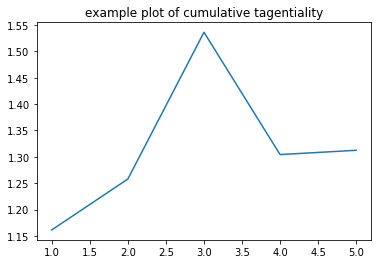

In [52]:
file = [['я','идти'],['идти','далеко'], ['пойти'], ['корзина','полный'], 
        ['ехать','на','велосипед'], ['в','деревня','подойти']]
file_sim = get_cumulative_tangentiality_array(file)
plt.plot(np.arange(len(file_sim))+1,file_sim)
plt.title(label='example plot of cumulative semi-local coherence')

now let us try it on an example from the sample

Text(0.5, 1.0, 'example of cumulative tangentiality applied on texts from the sample')

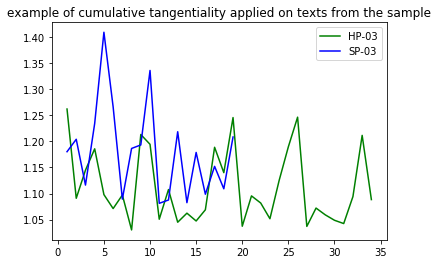

In [53]:
files = [sample['control']['HP-03'], sample['schizo']['SP-03']]
file_sim_1 = get_cumulative_tangentiality_array(files[0])
file_sim_2 = get_cumulative_tangentiality_array(files[1])
plt.plot(np.arange(len(file_sim_1))+1,file_sim_1, color='g', label='HP-03')
plt.plot(np.arange(len(file_sim_2))+1,file_sim_2, color='b', label='SP-03')
plt.legend()
plt.title(label='example of cumulative semi-local coherence applied on texts from the sample')

In [15]:
def random_color():
    return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])

now let us draw the real sample (control and schizo separately)

Text(0.5, 1.0, 'cumulative tangentiality of control texts')

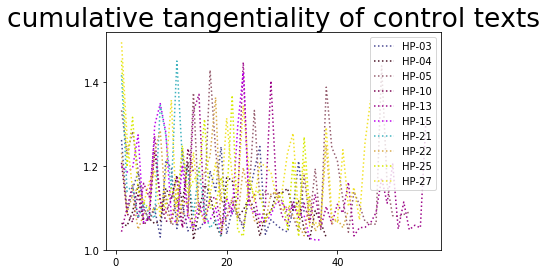

In [56]:
for filename in sample['control']:
    file = sample['control'][filename]
    file_sim = get_cumulative_tangentiality_array(file)
    plt.plot(np.arange(len(file_sim))+1, file_sim, color=random_color(), label=filename, linestyle=':')
plt.legend()
plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})
plt.title(label='cumulative semi-local coherence of control texts')

Text(0.5, 1.0, 'cumulative tangentiality of schizo texts')

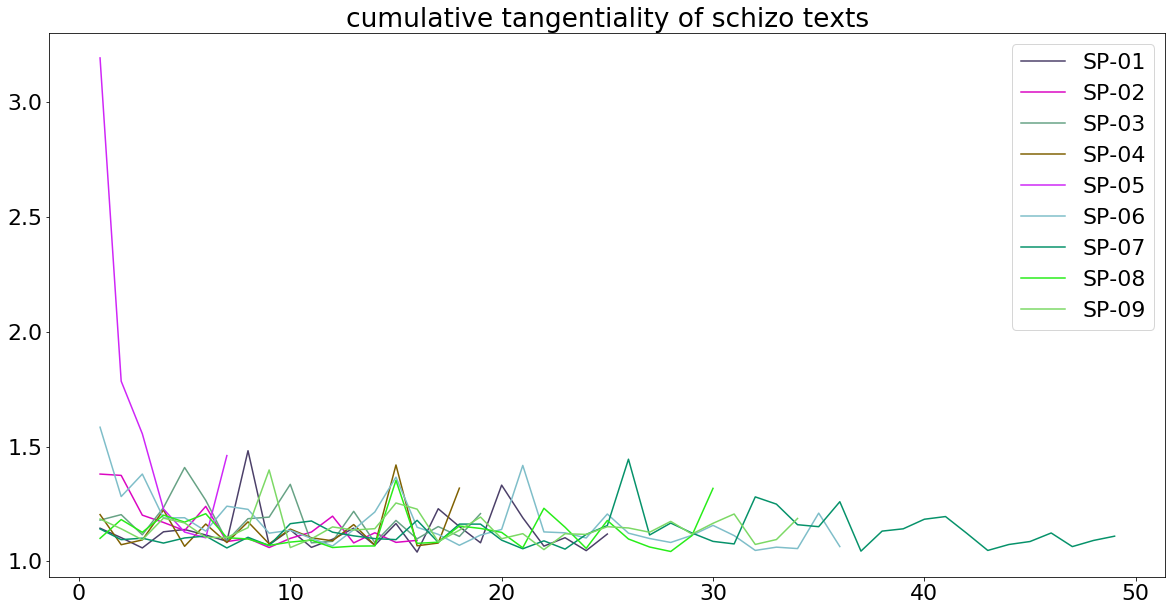

In [57]:
for filename in sample['schizo']:
    file = sample['schizo'][filename]
    file_sim = get_cumulative_tangentiality_array(file)
    plt.plot(np.arange(len(file_sim))+1,file_sim, random_color(), label=filename, linestyle='-')
plt.legend()
plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})
plt.title(label='cumulative semi-local coherence of schizo texts')

__okay, that is hard to comprehend this plots, they are overcrowded<br>
let us invent a technique for averaging a group of texts__

In [14]:
def average_text_vector_dict(array_of_arrays):
    max_len = max([len(x) for x in array_of_arrays])
    result_dict = {'min':[],'med':[],'max':[]}
    for i in range(max_len):
        current = []
        for arr in array_of_arrays:
            try:
                current.append(arr[i])
            except IndexError:
                continue
        if current:
            result_dict['min'].append(min(current))
            result_dict['max'].append(max(current))
            result_dict['med'].append(np.median(current))
        else:
            print(i, max_len)
    return result_dict

let us also create a function for plotting this average

In [15]:
def plot_average(result_dict, labels={'med':'median', 'min':'minimum', 'max':'maximum'},
                 colors={'med':'r', 'min':'#fd5c74', 'max':'#fd5c74'}, title='averaged metric'):
    length = len(result_dict['med'])
    plt.plot(np.arange(length)+1, result_dict['med'], color=colors['med'], label=labels['med'], linestyle='-')
    plt.plot(np.arange(length)+1, result_dict['min'], color=colors['min'], label=labels['min'], linestyle=':')
    plt.plot(np.arange(length)+1, result_dict['max'], color=colors['max'], label=labels['max'], linestyle=':')
    plt.title(label=title)
    plt.legend()
    plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})

let us test it on a simple example

In [60]:
average_ex = average_text_vector_dict([[1, 7, 8],[2, 3, 4],[-2, 12, 0.35, 21], [], [0.1, 1]])

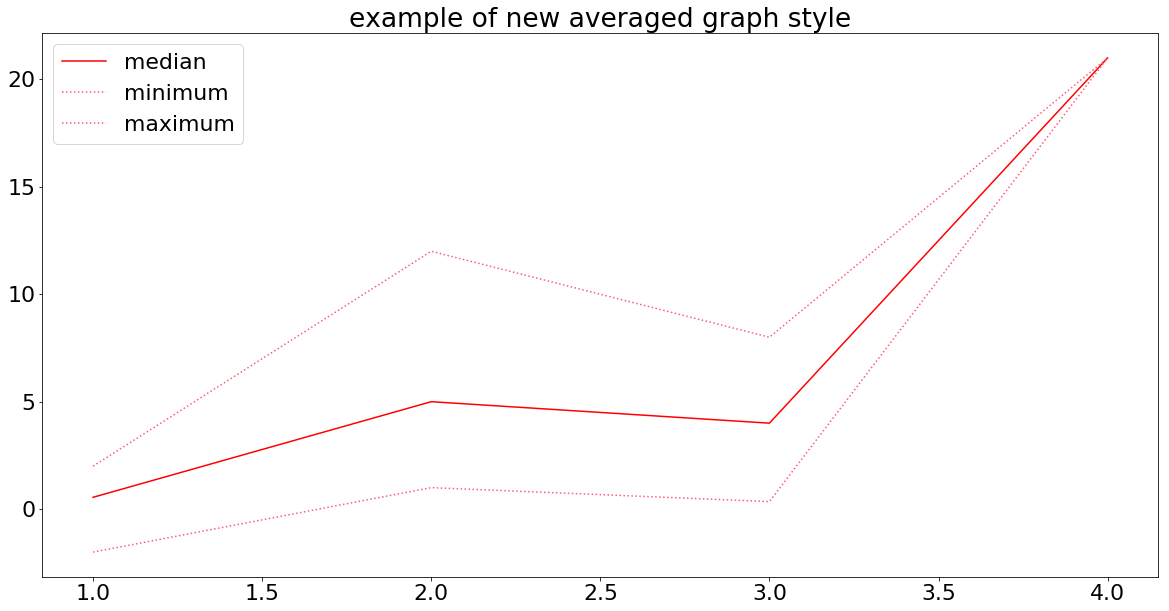

In [61]:
plot_average(average_ex, title = 'example of new averaged graph style')

__let us now average sample texts and plot them__

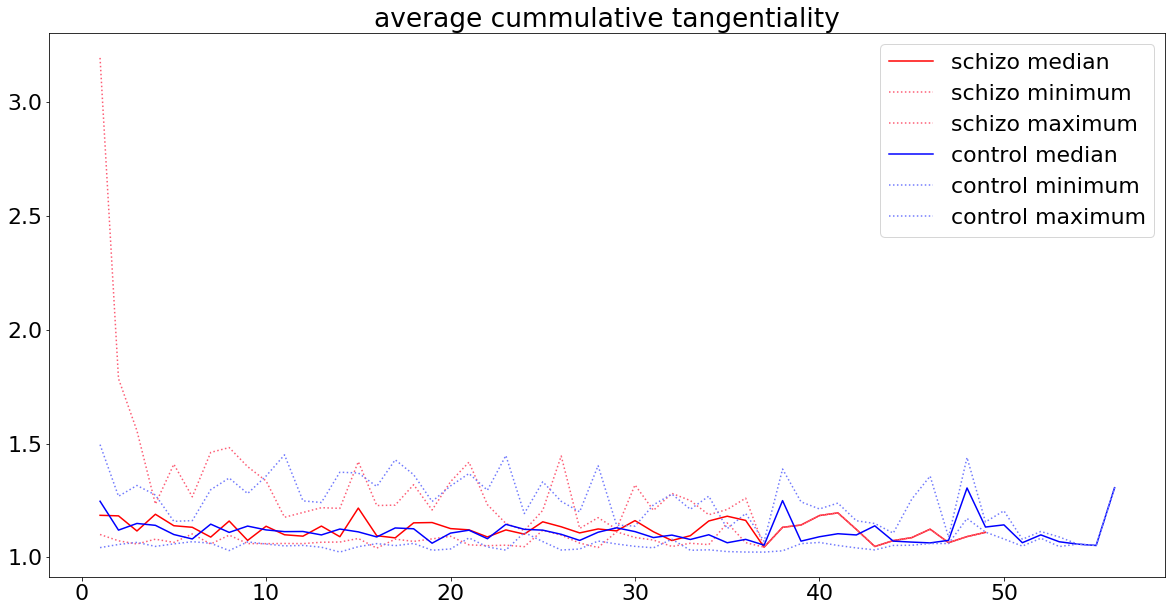

In [62]:
schizo_sim_array = []
for filename in sample['schizo']:
    file = sample['schizo'][filename]
    schizo_sim_array.append(get_cumulative_tangentiality_array(file))
schizo_average_dict = average_text_vector_dict(schizo_sim_array)
plot_average(schizo_average_dict, labels={'med':'schizo median', 'min':'schizo minimum', 'max':'schizo maximum'})

control_sim_array = []
for filename in sample['control']:
    file = sample['control'][filename]
    control_sim_array.append(get_cumulative_tangentiality_array(file))
control_average_dict = average_text_vector_dict(control_sim_array)
plot_average(control_average_dict, labels={'med':'control median', 'min':'control minimum', 'max':'control maximum'}, 
             colors={'med':'b', 'min':'#717afd', 'max':'#717afd'}, title='average cummulative semi-local coherence')

__let us calculate how tangential the last clause is to the whole of the story__<br>
__let us also calculate the average cumulative semi-local coherence of each story__

In [65]:
patient_last_cum_tan = {'control':[], 'schizo':[]}
patient_average_cum_tan = {'control':[], 'schizo':[]}
last_cum_tan_series = []
average_cum_tan_series = []
for i in patient_df.index:
    filename = patient_df.at[i, 'ID']
    group = patient_df.at[i, 'group']
    file = sample[group][filename]
    file_sim = get_cumulative_tangentiality_array(file)
    last_cum_tan_series.append(file_sim[-1])
    average_cum_tan_series.append(np.mean(file_sim))
    patient_last_cum_tan[group].append(file_sim[-1])
    patient_average_cum_tan[group].append(np.mean(file_sim))

__let us add the data to our dataframe__

In [296]:
patient_df['last_cum_tan'] = pd.Series(last_cum_tan_series,index=patient_df.index)
patient_df['av_cum_tan'] = pd.Series(average_cum_tan_series,index=patient_df.index)

In [301]:
patient_df.head()

,ID,group,diagnosis,num_utt,man_gcoh,man_av_gcoh,man_compl_viol,man_compl_viol_per_utt,man_lcoh,man_av_lcoh,last_cum_tan,av_cum_tan,av_loc_coh
0,SP-01,schizo,1,26,112,4.307692,0,0.000000,97,3.730769,0.893185,0.886196,0.809226
1,SP-02,schizo,1,17,67,3.941176,3,0.176471,61,3.588235,0.915624,0.867483,0.817666
2,SP-03,schizo,1,20,84,4.200000,2,0.100000,69,3.450000,0.827491,0.851275,0.772379
3,SP-04,schizo,1,19,83,4.368421,1,0.052632,70,3.684211,0.757857,0.878585,0.812038
4,SP-05,schizo,1,9,27,3.000000,4,0.444444,22,2.444444,0.684295,0.686679,0.702189


__let us save the df__

In [474]:
patient_df.to_csv(path_or_buf='df.csv', sep=',')

__let us plot the cummulative semi-local coherence of the last clause for each patient in each group by their rank__

Text(0.5, 0, 'patient rank on cumulative tangentiality of the last clause')

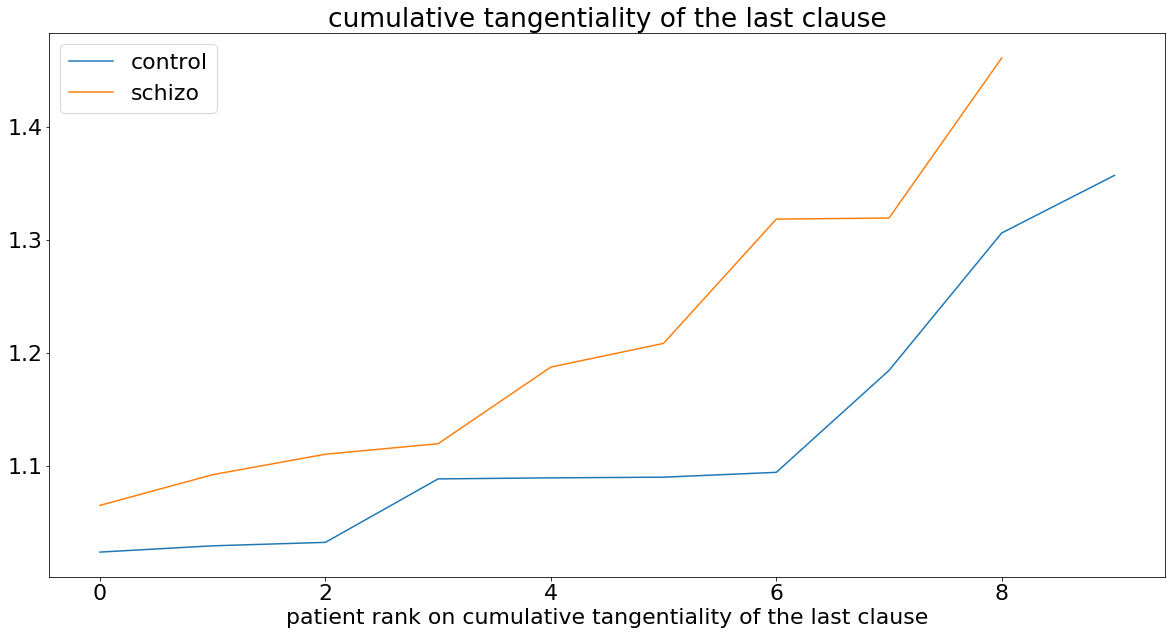

In [64]:
plt.plot(sorted(patient_last_cum_tan['control']), label='control')
plt.plot(sorted(patient_last_cum_tan['schizo']), label='schizo')
plt.legend()
plt.title(label='cumulative semi-local coherence of the last clause')
plt.xlabel('patient rank on cumulative semi-local coherence of the last clause')

__let us plot the average cumulative semi-local coherence for each patient in each group (by rank)__

Text(0.5, 0, 'patient rank on average cumulative tangentiality')

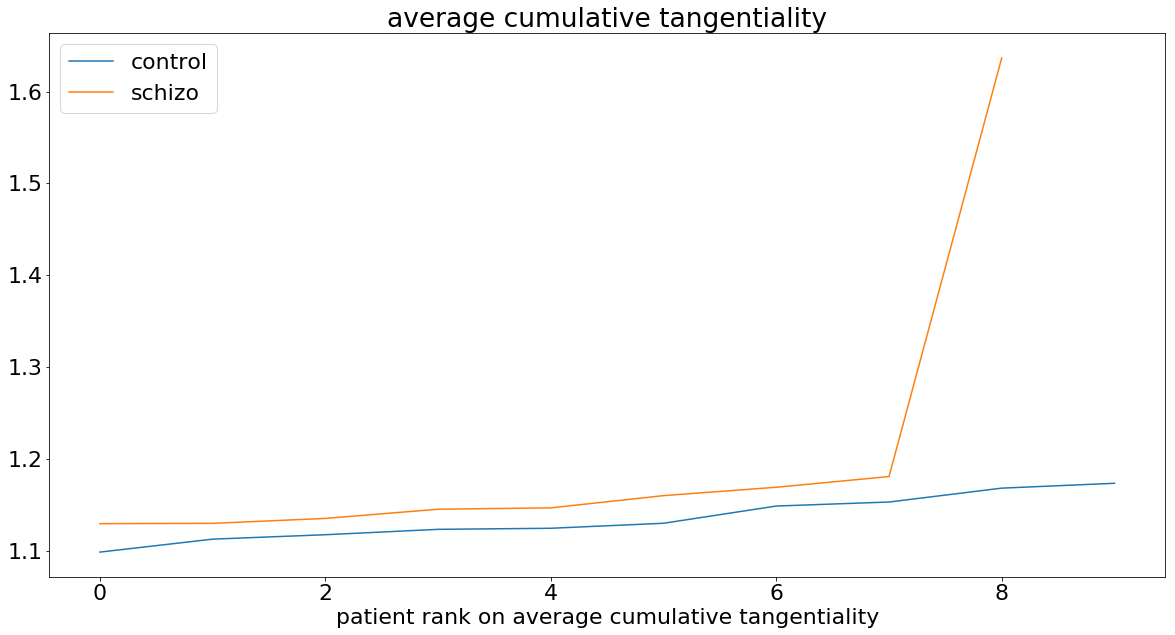

In [66]:
plt.plot(sorted(patient_average_cum_tan['control']), label='control')
plt.plot(sorted(patient_average_cum_tan['schizo']), label='schizo')
plt.legend()
plt.title(label='average cumulative semi-local coherence')
plt.xlabel('patient rank on average cumulative semi-local coherence')

__the last schizo patient's story is too tangential! <br>
let us see the picture without the first patient from schizo group!__

Text(0.5, 0, 'patient rank on average cumulative tangentiality')

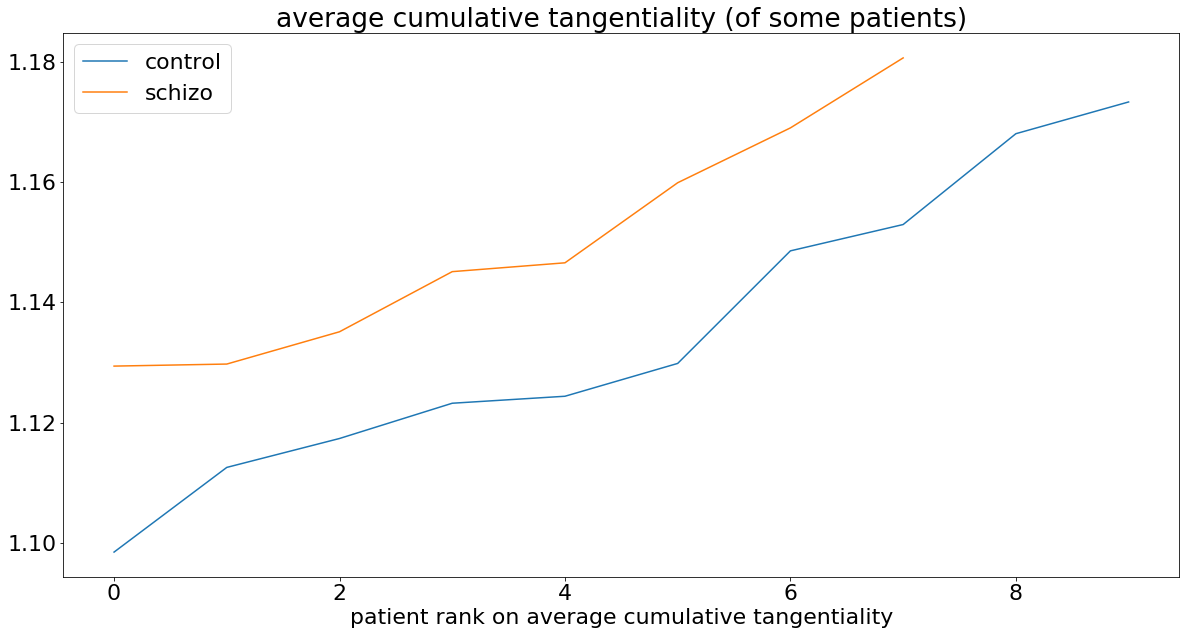

In [68]:
plt.plot(sorted(patient_average_cum_tan['control']), label='control')
plt.plot(sorted(patient_average_cum_tan['schizo'])[:-1], label='schizo')
plt.legend()
plt.title(label='average cumulative semi-local coherence (of some patients)')
plt.xlabel('patient rank on average cumulative semi-local coherence')

### Local coherence
(let i = cosine distance between an averaged vector of the neighbouring clauses)
<ul>
    <li>a plot: <br>
        x axis: number of the current clause <br>
        y axis: i</li>
    <li>the differences between the averages for the groups</li>
    <li>the differences between the averages for the averages of the groups</li>
</ul>

In [69]:
def get_local_coherence_array(clauses):
    clause_vectors = get_file_clause_vectors(clauses)
    local_coherence_array = []
    length = len(clause_vectors)
    for i in range(length-1):
        local_coherence_array.append(cos_sim(clause_vectors[i], clause_vectors[i+1]))
    return [1/x for x in local_coherence_array]

let us see how it works on an example

Text(0.5, 1.0, 'example plot of local coherence')

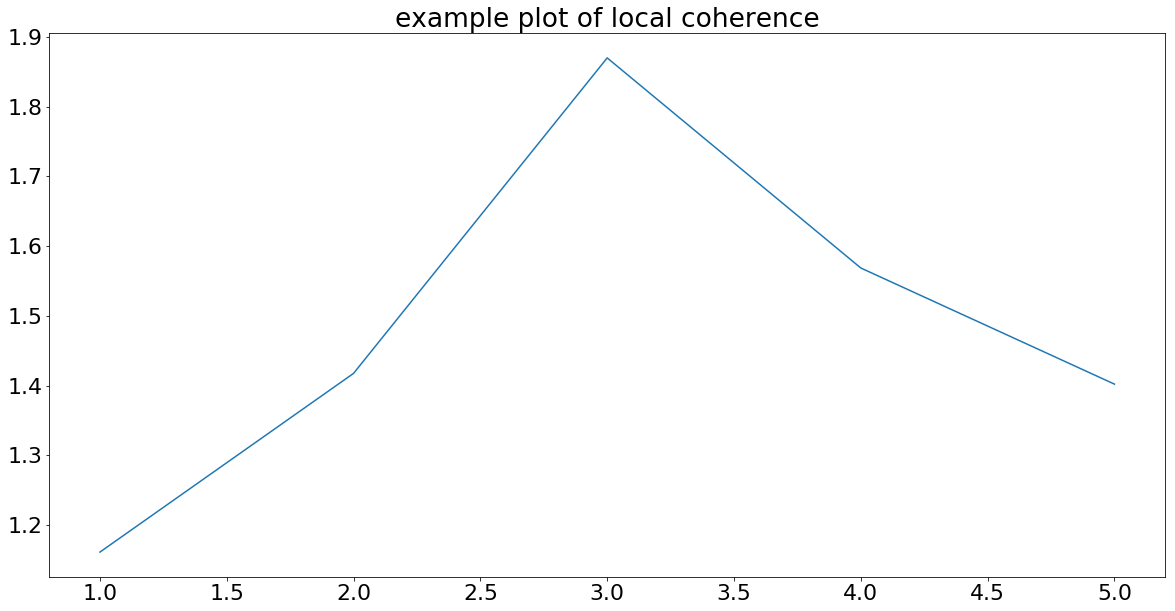

In [70]:
file = [['я','идти'],['идти','далеко'], ['пойти'], ['корзина','полный'], 
        ['ехать','на','велосипед'], ['в','деревня','подойти']]
local_coherence_array = get_local_coherence_array(file)
plt.plot(np.arange(len(local_coherence_array))+1,local_coherence_array)
plt.title(label='example plot of local coherence')

__let us plot local coherence of both groups__

Text(0.5, 1.0, 'local coherence of control texts')

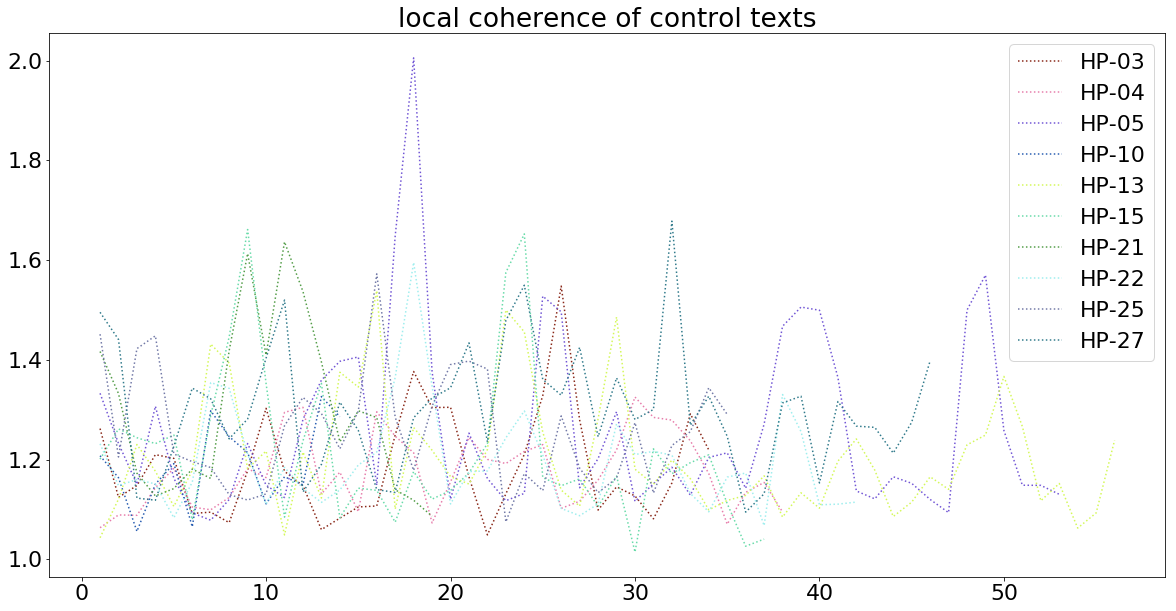

In [71]:
for filename in sample['control']:
    file = sample['control'][filename]
    local_coherence_array = get_local_coherence_array(file)
    plt.plot(np.arange(len(local_coherence_array))+1, local_coherence_array, color=random_color(), label=filename, linestyle=':')
plt.legend()
plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})
plt.title(label='local coherence of control texts')

Text(0.5, 1.0, 'local coherence of schizo texts')

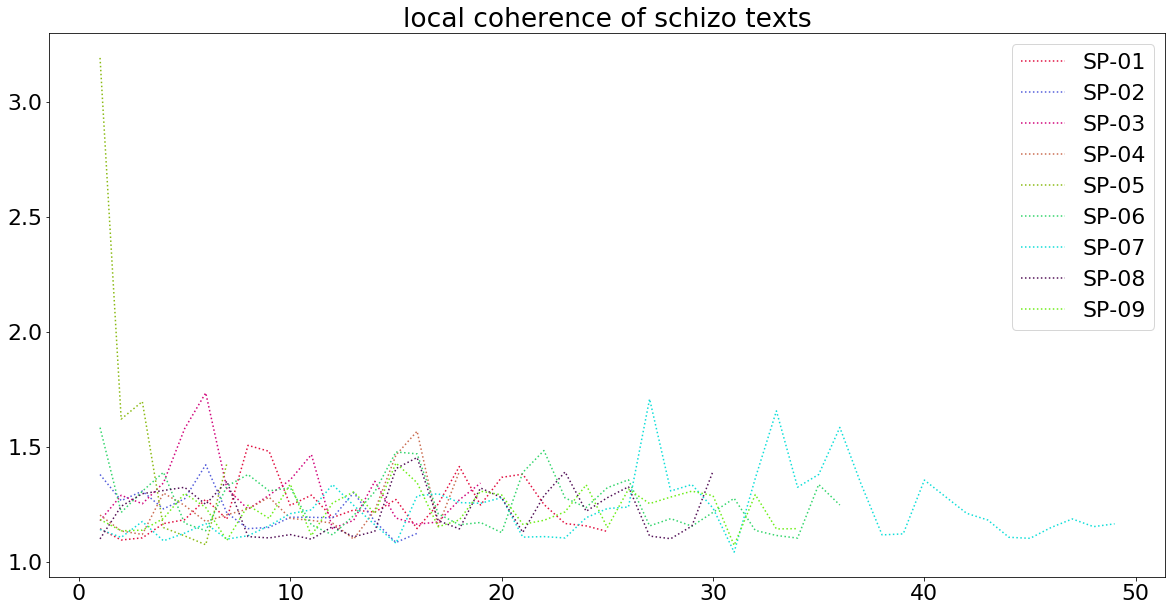

In [72]:
for filename in sample['schizo']:
    file = sample['schizo'][filename]
    local_coherence_array = get_local_coherence_array(file)
    plt.plot(np.arange(len(local_coherence_array))+1, local_coherence_array, color=random_color(), label=filename, linestyle=':')
plt.legend()
plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})
plt.title(label='local coherence of schizo texts')

__let us also plot the average local coherence in both groups__

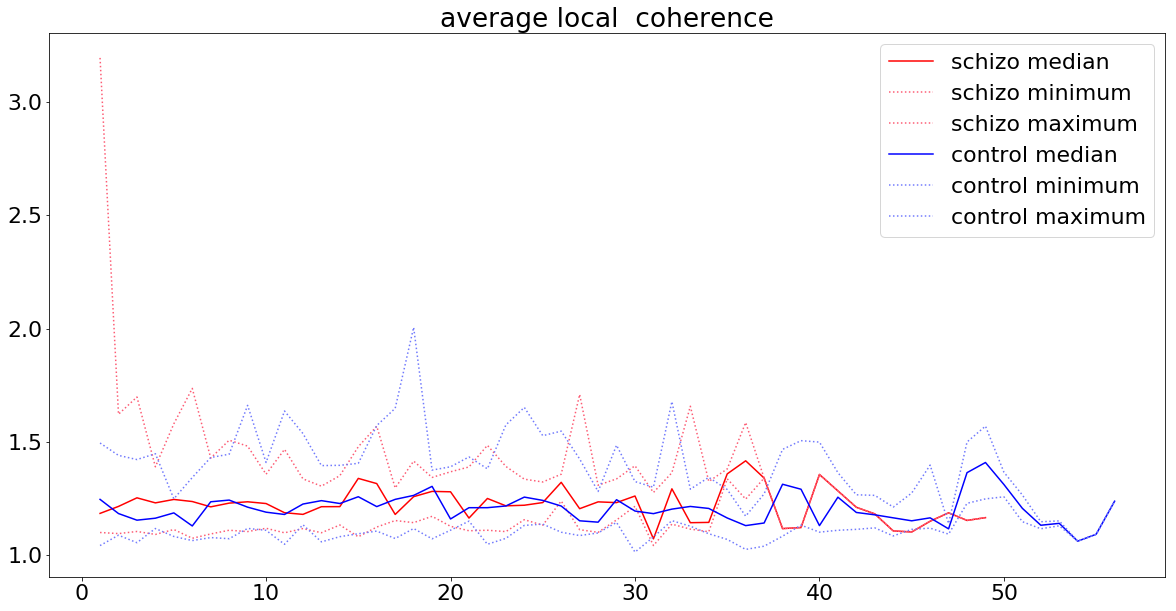

In [73]:
schizo_local_coherence_array = []
for filename in sample['schizo']:
    file = sample['schizo'][filename]
    schizo_local_coherence_array.append(get_local_coherence_array(file))
schizo_average_dict = average_text_vector_dict(schizo_local_coherence_array)
plot_average(schizo_average_dict, labels={'med':'schizo median', 'min':'schizo minimum', 'max':'schizo maximum'})

control_local_coherence_array = []
for filename in sample['control']:
    file = sample['control'][filename]
    control_local_coherence_array.append(get_local_coherence_array(file))
control_average_dict = average_text_vector_dict(control_local_coherence_array)
plot_average(control_average_dict, labels={'med':'control median', 'min':'control minimum', 'max':'control maximum'}, 
             colors={'med':'b', 'min':'#717afd', 'max':'#717afd'}, title='average local  coherence')

__let us calculate and plot the average local coherence for each patient in each group (by rank)__

In [74]:
patient_average_loc_coh = {'control':[], 'schizo':[]}
average_loc_coh_series = []
for i in patient_df.index:
    filename = patient_df.at[i, 'ID']
    group = patient_df.at[i, 'group']
    file = sample[group][filename]
    file_sim = get_local_coherence_array(file)
    average_loc_coh_series.append(np.mean(file_sim))
    patient_average_loc_coh[group].append(np.mean(file_sim))

__let us add the data to our dataframe__

In [298]:
patient_df['av_loc_coh'] = pd.Series(average_loc_coh_series,index=patient_df.index)

In [302]:
patient_df.head()

,ID,group,diagnosis,num_utt,man_gcoh,man_av_gcoh,man_compl_viol,man_compl_viol_per_utt,man_lcoh,man_av_lcoh,last_cum_tan,av_cum_tan,av_loc_coh
0,SP-01,schizo,1,26,112,4.307692,0,0.000000,97,3.730769,0.893185,0.886196,0.809226
1,SP-02,schizo,1,17,67,3.941176,3,0.176471,61,3.588235,0.915624,0.867483,0.817666
2,SP-03,schizo,1,20,84,4.200000,2,0.100000,69,3.450000,0.827491,0.851275,0.772379
3,SP-04,schizo,1,19,83,4.368421,1,0.052632,70,3.684211,0.757857,0.878585,0.812038
4,SP-05,schizo,1,9,27,3.000000,4,0.444444,22,2.444444,0.684295,0.686679,0.702189


__let us save the df__

In [472]:
patient_df.to_csv(path_or_buf='df.csv', sep=',')

Text(0.5, 0, 'patient rank on average local coherence')

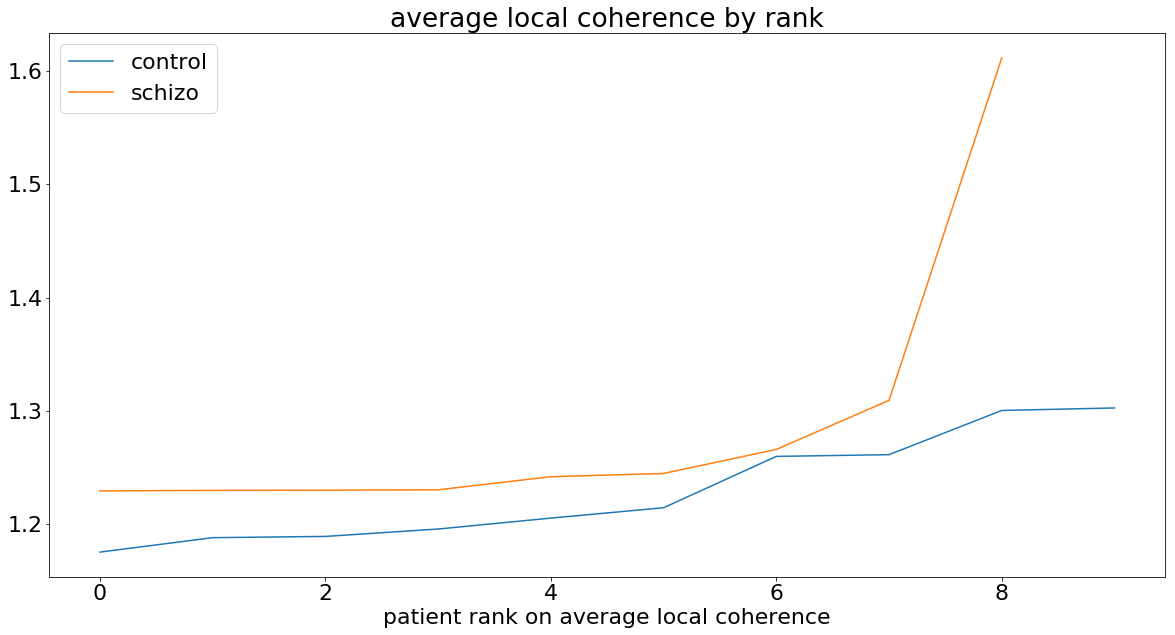

In [75]:
plt.plot(sorted(patient_average_loc_coh['control']), label='control')
plt.plot(sorted(patient_average_loc_coh['schizo']), label='schizo')
plt.legend()
plt.title(label='average local coherence by rank')
plt.xlabel('patient rank on average local coherence')

## let us now draw some ROC-curves

Text(0, 0.5, 'True Positive Rate')

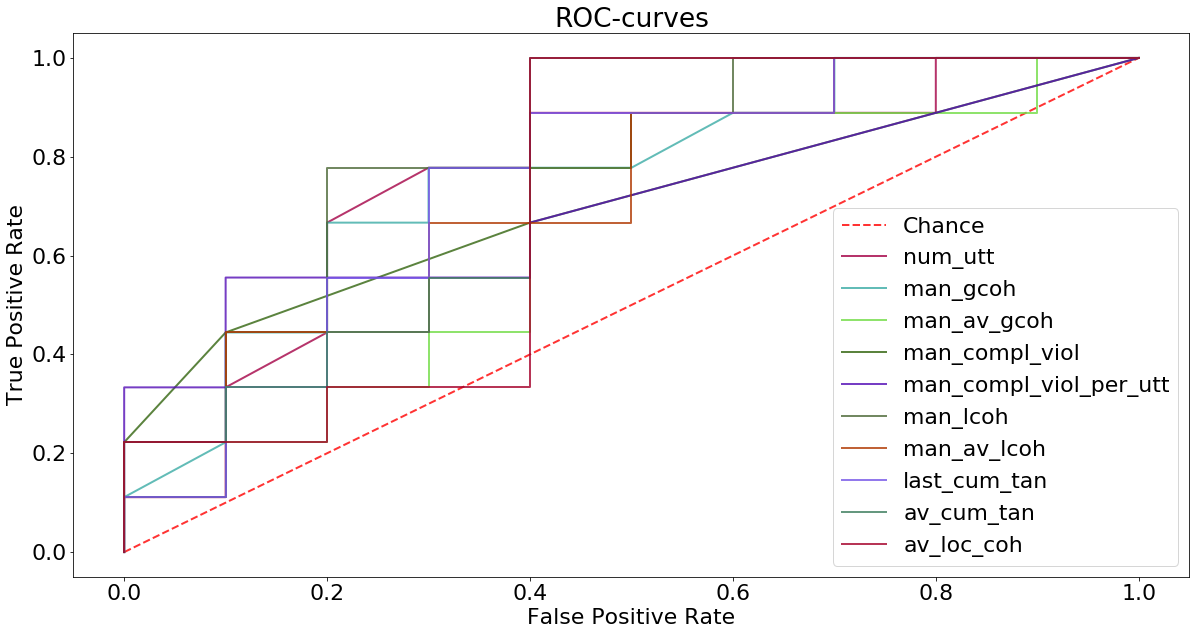

In [167]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
for col in patient_df.keys()[3:]:
    y = patient_df['diagnosis']
    x = patient_df[col]
    fpr, tpr, thresholds = metrics.roc_curve(y, x, pos_label=1)
    plt.plot(fpr, tpr, label=col, lw=2, alpha=.8, color=random_color())
plt.legend(loc='lower right')
plt.title(label='ROC-curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [168]:
for col in patient_df.keys()[3:]:
    y = patient_df['diagnosis']
    x = patient_df[col]
    print(col, metrics.roc_auc_score(y, x))

num_utt 0.7555555555555555
man_gcoh 0.7555555555555555
man_av_gcoh 0.6555555555555556
man_compl_viol 0.7
man_compl_viol_per_utt 0.7
man_lcoh 0.7777777777777778
man_av_lcoh 0.7222222222222222
last_cum_tan 0.7444444444444445
av_cum_tan 0.7555555555555555
av_loc_coh 0.711111111111111


## let us try some machine learning

__let us split the sample__

In [6]:
array_all = patient_df.values[:,2:]
X = [list(x) for x in array_all[:, 1:]]
y = list(array_all[:, 0])

In [7]:
scores = ['accuracy', 'precision', 'recall', 'f1']
kernels = ['linear', 'rbf']
loo = LeaveOneOut()

### let us see some metrics and visually compare these

In [10]:
def manual_fit_cv(cvs, clf):
    fits = {}
    for scoring in scores:
        fits[scoring] = []
        for cv in cvs:
            fit_scores = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
            fits[scoring].append({'mean' : fit_scores.mean(), 'std' : fit_scores.std()})
    return fits

In [11]:
k_fit_cv = {}
for kernel in kernels:
    clf = svm.SVC(kernel=kernel, C=10, gamma='scale')
    k_fit_cv[kernel] = manual_fit_cv(range(3,7), clf)

k_fit_cv

{'linear': {'accuracy': [{'mean': 0.6825396825396824,
    'std': 0.022447834323382487},
   {'mean': 0.5666666666666667, 'std': 0.07071067811865474},
   {'mean': 0.5166666666666667, 'std': 0.20682789409984761},
   {'mean': 0.638888888888889, 'std': 0.21872244094477256}],
  'precision': [{'mean': 0.7555555555555555, 'std': 0.17497795275581804},
   {'mean': 0.41666666666666663, 'std': 0.24999999999999997},
   {'mean': 0.36666666666666664, 'std': 0.30550504633038933},
   {'mean': 0.47222222222222215, 'std': 0.36535962327683075}],
  'recall': [{'mean': 0.6666666666666666, 'std': 0.2721655269759087},
   {'mean': 0.5416666666666666, 'std': 0.36084391824351614},
   {'mean': 0.5, 'std': 0.4472135954999579},
   {'mean': 0.5833333333333334, 'std': 0.44876373392787533}],
  'f1': [{'mean': 0.6388888888888888, 'std': 0.10393492741038722},
   {'mean': 0.4583333333333333, 'std': 0.27322660517925},
   {'mean': 0.42000000000000004, 'std': 0.36},
   {'mean': 0.5166666666666667, 'std': 0.39334745737353155

In [254]:
def manual_fit_loo(clf):
    fits = {}
    for scoring in scores:
        fits[scoring] = {}
        scores_3 = cross_val_score(clf, X, y, cv=3, scoring=scoring)
        fits[scoring]['3-fold'] = scores_3.mean()
        scores_loo = cross_val_score(clf, X, y, cv=loo, scoring=scoring)
        fits[scoring]['loo'] = scores_loo.mean()
##        print(scoring, '3-fold', scores_3.mean(), 'loo', scores_loo.mean())

    all_1 = np.ones_like(y)
    accuracy_loo = cross_val_score(clf, X, y, cv=loo)
##    print('loo total (p/r/f1)',
##          metrics.precision_score(accuracy_loo, all_1),
##          metrics.recall_score(accuracy_loo, all_1),
##          metrics.f1_score(accuracy_loo, all_1))
    fits['loo total'] = {'precision' : metrics.precision_score(accuracy_loo, all_1), 
                         'recall' : metrics.recall_score(accuracy_loo, all_1),
                         'f1' : metrics.f1_score(accuracy_loo, all_1)}
    return fits

In [262]:
k_fit_loo = {}
for kernel in kernels:
    clf = svm.SVC(kernel=kernel, C=10, gamma='scale')
    k_fit_loo[kernel] = manual_fit_loo(clf)

k_fit_loo

{'linear': {'accuracy': {'3-fold': 0.6349206349206349,
   'loo': 0.5789473684210527},
  'precision': {'3-fold': 0.5, 'loo': 0.21052631578947367},
  'recall': {'3-fold': 0.3333333333333333, 'loo': 0.21052631578947367},
  'f1': {'3-fold': 0.4000000000000001, 'loo': 0.21052631578947367},
  'loo total': {'precision': 0.5789473684210527,
   'recall': 1.0,
   'f1': 0.7333333333333334}},
 'rbf': {'accuracy': {'3-fold': 0.626984126984127, 'loo': 0.5263157894736842},
  'precision': {'3-fold': 0.8333333333333334, 'loo': 0.10526315789473684},
  'recall': {'3-fold': 0.3333333333333333, 'loo': 0.10526315789473684},
  'f1': {'3-fold': 0.4666666666666666, 'loo': 0.10526315789473684},
  'loo total': {'precision': 0.5263157894736842,
   'recall': 1.0,
   'f1': 0.6896551724137931}}}

### let us automatically fit these
source code for this part  [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py)<br>
don't blame me: we all copy-paste, and I even thougth while doing it

In [203]:
best_parametrs = {}
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=0)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5,
                       scoring=score)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    best_parametrs[score] = clf.best_params_
    
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for accuracy



c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.526 (+/-0.122) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.526 (+/-0.122) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.526 (+/-0.122) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.526 (+/-0.122) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.632 (+/-0.497) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.526 (+/-0.122) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.684 (+/-0.482) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.632 (+/-0.497) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.684 (+/-0.482) for {'C': 1, 'kernel': 'linear'}
0.632 (+/-0.399) for {'C': 10, 'kernel': 'linear'}
0.579 (+/-0.388) for {'C': 100, 'kernel': 'linear'}
0.526 (+/-0.260) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

           

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.579 (+/-0.987) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.789 (+/-0.815) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.579 (+/-0.987) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.789 (+/-0.815) for {'C': 1, 'kernel': 'linear'}
0.711 (+/-0.815) for {'C': 10, 'kernel': 'linear'}
0.605 (+/-0.766) for {'C': 100, 'kernel': 'linear'}
0.298 (+/-0.547) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

           

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.368 (+/-0.714) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.000 (+/-0.000) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.474 (+/-0.605) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.368 (+/-0.714) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.474 (+/-0.605) for {'C': 1, 'kernel': 'linear'}
0.474 (+/-0.605) for {'C': 10, 'kernel': 'linear'}
0.474 (+/-0.605) for {'C': 100, 'kernel': 'linear'}
0.474 (+/-0.887) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

           

c:\users\lgpc\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [193]:
best_parametrs

{'accuracy': {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'},
 'precision': {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'},
 'recall': {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'},
 'f1': {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}}

### let us manually fit these again

In [267]:
clf = svm.SVC(kernel='rbf', gamma=0.001, C = 1000)
final_fit_loo = manual_fit_loo(clf)

{'accuracy': {'3-fold': 0.6825396825396824, 'loo': 0.631578947368421},
 'precision': {'3-fold': 0.8333333333333334, 'loo': 0.21052631578947367},
 'recall': {'3-fold': 0.4444444444444444, 'loo': 0.21052631578947367},
 'f1': {'3-fold': 0.5666666666666668, 'loo': 0.21052631578947367},
 'loo total': {'precision': 0.631578947368421,
  'recall': 1.0,
  'f1': 0.7741935483870968}}

In [13]:
clf = svm.SVC(kernel='rbf', gamma=0.001, C = 1000)
final_fit_cv = manual_fit_cv(range(2,7), clf)

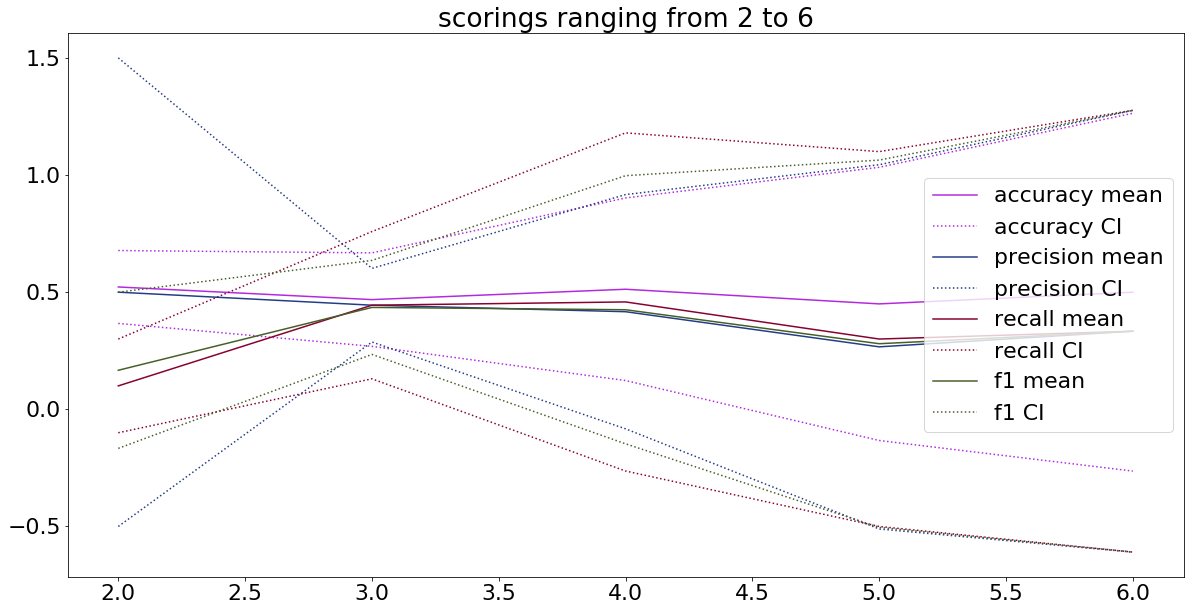

In [19]:
plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})
for scoring in scores:
    color = random_color()
    current = final_fit_cv[scoring]
    means = [d['mean'] for d in current]
    mins = [d['mean']-2*d['std'] for d in current]
    maxs = [d['mean']+2*d['std'] for d in current]
    plt.plot(np.arange(5)+2, means, color=color, label='%s mean'%(scoring), linestyle='-')
    plt.plot(np.arange(5)+2, mins, color=color, label='%s CI'%(scoring), linestyle=':')
    plt.plot(np.arange(5)+2, maxs, color=color, linestyle=':')
plt.title(label='scorings ranging from 2 to 6')
plt.legend()

<h3 style='color:red'>To be implemented later</h3>
<h3>Global coherence</h3>
    (let us take a weighted average of each clause, then an average of these centroids in one text, then a average of the averages of all the texts at hand)
<ul>
    <li>cosine distance between the average of all the texsts and the average of the current text for each partcipant</li>
    <li>cosine distance between the average of all the <i>control</i> texsts and the average of the current text for each partcipant</li>
</ul>

__let us create a function for comparing a text to one standard vector__

In [39]:
def compare_text_to_a_standard_vector(file, standard_vector):
    average_file_vector = np.average(get_file_clause_vectors(file), axis=0)
    return cos_sim(average_file_vector, standard_vector)

__let us define two standard vectors for two global coherence measures__ <br>
<p>
    all_texts_vector - for all texts <br>
    control_texts_vector - for control texts only
</p>

In [29]:
all_texts_vector = np.ndarray(300)
control_texts_vector = np.ndarray(300)
for key in ['control', 'schizo']:
    for filename in sample[key]:
        file = sample[key][filename]
        if key == 'control':
            control_texts_vector += np.average(get_file_clause_vectors(file), axis=0)
        control_texts_vector = np.average(get_file_clause_vectors(file), axis=0)

__let us calculate and plot the global coherence for each patient in each group (by rank)__

In [71]:
patient_glob_coh = {'control':[], 'schizo':[]}
patient_control_glob_coh = {'control':[], 'schizo':[]}
patient_man_glob_coh = {'control':[], 'schizo':[]}
glob_coh_series = []
control_glob_coh_series = []
for i in patient_df.index:
    filename = patient_df.at[i, 'ID']
    group = patient_df.at[i, 'group']
    man_av_glob_coh = patient_df.at[i, 'man_av_gcoh']
    file = sample[group][filename]
    glob_coh = compare_text_to_a_standard_vector(file, all_texts_vector)
    control_glob_coh = compare_text_to_a_standard_vector(file, control_texts_vector)
    glob_coh_series.append(glob_coh)
    control_glob_coh_series.append(control_glob_coh)
    patient_glob_coh[group].append(glob_coh)
    patient_control_glob_coh[group].append(control_glob_coh)
    patient_man_glob_coh[group].append(man_av_glob_coh/5)

__let us add the data to our dataframe__

In [64]:
patient_df['gcoh'] = pd.Series(glob_coh_series,index=patient_df.index)
patient_df['control_gcoh'] = pd.Series(control_glob_coh_series,index=patient_df.index)

In [65]:
patient_df

,ID,group,diagnosis,num_utt,man_gcoh,man_av_gcoh,man_compl_viol,man_compl_viol_per_utt,man_lcoh,man_av_lcoh,glob_coh,control_glob_coh,gcoh,control_gcoh
0,SP-01,schizo,1,26,112,4.307692,0,0.000000,97,3.730769,0.874449,0.986190,0.874449,0.986190
1,SP-02,schizo,1,17,67,3.941176,3,0.176471,61,3.588235,0.868464,0.981660,0.868464,0.981660
2,SP-03,schizo,1,20,84,4.200000,2,0.100000,69,3.450000,0.871864,0.985637,0.871864,0.985637
3,SP-04,schizo,1,19,83,4.368421,1,0.052632,70,3.684211,0.868929,0.987610,0.868929,0.987610
4,SP-05,schizo,1,9,27,3.000000,4,0.444444,22,2.444444,0.829036,0.934263,0.829036,0.934263
5,SP-06,schizo,1,37,179,4.837838,0,0.000000,146,3.945946,0.879351,0.987482,0.879351,0.987482
6,SP-07,schizo,1,50,206,4.120000,1,0.020000,156,3.120000,0.876752,0.990087,0.876752,0.990087
7,SP-08,schizo,1,31,139,4.483871,0,0.000000,113,3.645161,0.884598,0.987895,0.884598,0.987895
8,SP-09,schizo,1,35,127,3.628571,2,0.057143,119,3.400000,0.902171,1.000000,0.902171,1.000000
9,HP-03,control,0,35,135,3.857143,0,0.000000,128,3.657143,0.878894,0.982887,0.878894,0.982887


__let us save the df__

In [61]:
patient_df.to_csv(path_or_buf='df.csv', sep=',')

Text(0.5, 0, 'patient rank on global coherence')

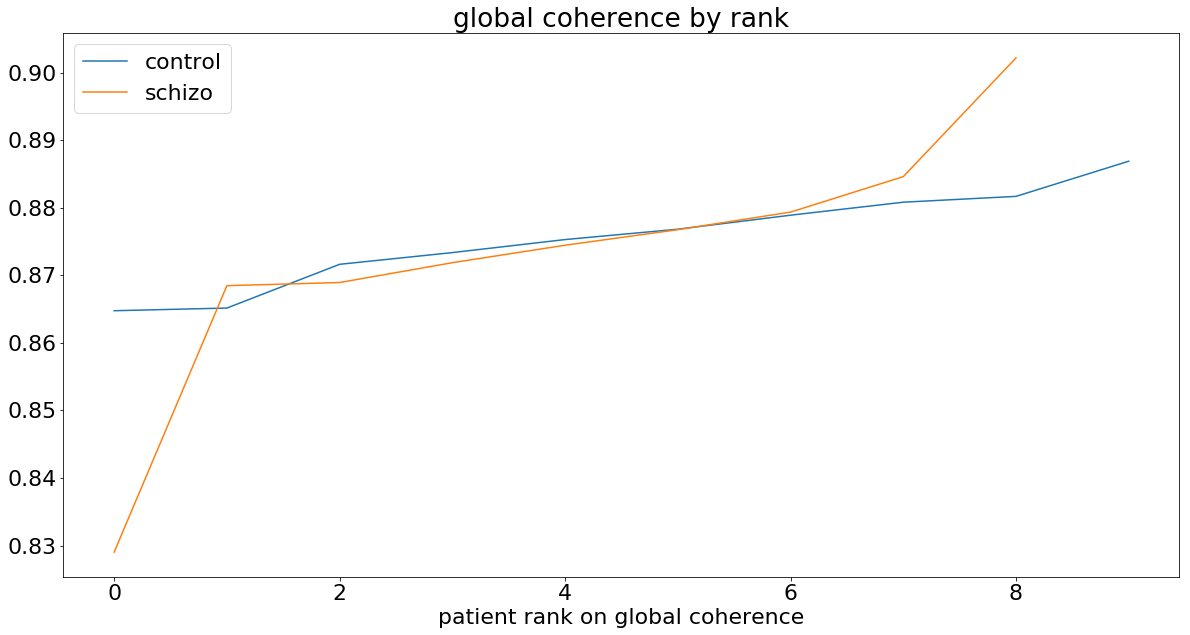

In [60]:
plt.rcParams.update({'font.size': 22, 'figure.figsize':[20,10]})
plt.plot(sorted(patient_glob_coh['control']), label='control')
plt.plot(sorted(patient_glob_coh['schizo']), label='schizo')
plt.legend()
plt.title(label='global coherence by rank')
plt.xlabel('patient rank on global coherence')

Text(0.5, 0, 'patient rank on control global coherence')

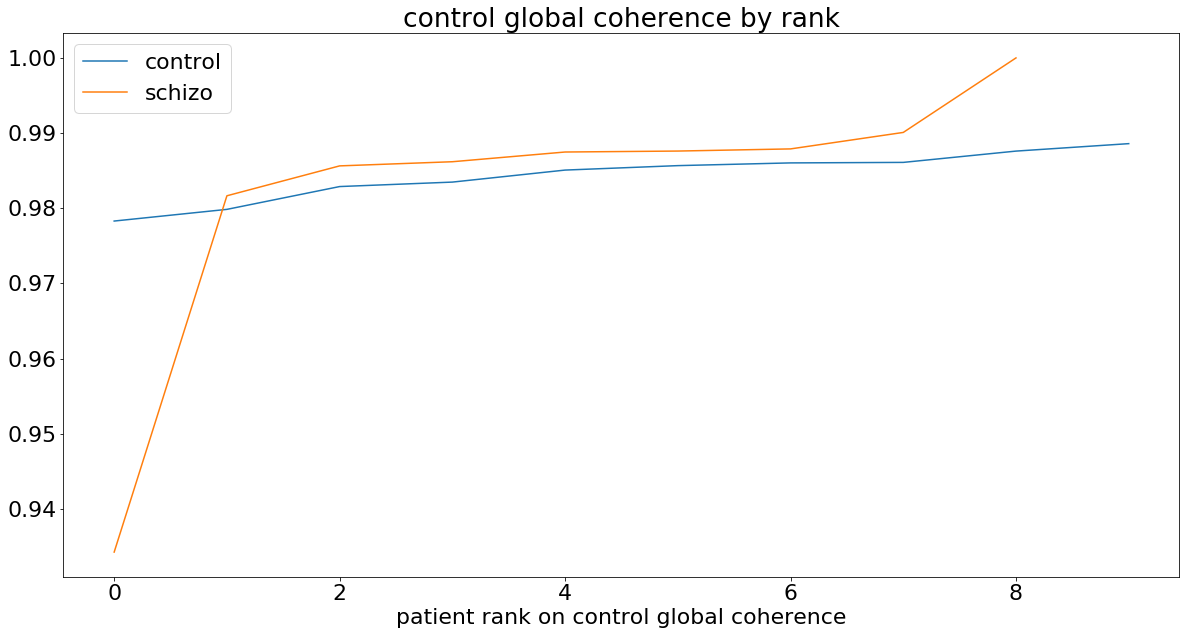

In [62]:
plt.plot(sorted(patient_control_glob_coh['control']), label='control')
plt.plot(sorted(patient_control_glob_coh['schizo']), label='schizo')
plt.legend()
plt.title(label='control global coherence by rank')
plt.xlabel('patient rank on control global coherence')

__let us plot the measures togeteher__

Text(0.5, 0, 'patient rank on manual, control and simple global coherence')

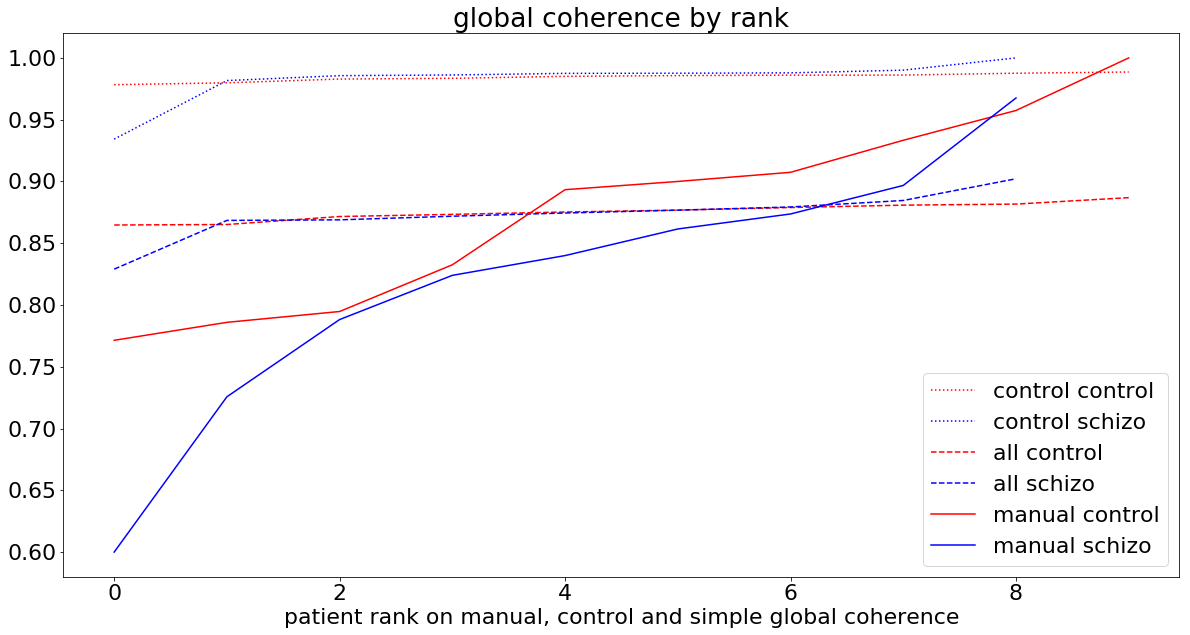

In [75]:
plt.plot(sorted(patient_control_glob_coh['control']), label='control control', linestyle=':', color='red')
plt.plot(sorted(patient_control_glob_coh['schizo']), label='control schizo', linestyle=':', color='blue')
plt.plot(sorted(patient_glob_coh['control']), label='all control', linestyle='--', color='red')
plt.plot(sorted(patient_glob_coh['schizo']), label='all schizo', linestyle='--', color='blue')
plt.plot(sorted(patient_man_glob_coh['control']), label='manual control', color='red')
plt.plot(sorted(patient_man_glob_coh['schizo']), label='manual schizo', color='blue')
plt.legend()
plt.title(label='global coherence by rank')
plt.xlabel('patient rank on manual, control and simple global coherence')

<h3>Violations of completeness</h3> 

(see levenshtein, needleman, wunsch [wiki: Levenshtein_distance](https://en.wikipedia.org/wiki/Levenshtein_distance) and [wiki: Needleman–Wunsch_algorithm](https://en.wikipedia.org/wiki/Needleman%E2%80%93Wunsch_algorithm))<br>
    (let the set of topics be defined as text (set_of_propositions.txt))
<ul>
    <li>cosine distance between the average of the topics and the average of the text</li>
    <li>cosine distance between each topic and each clause and alignment (see articles above, pay attention to the weight of the alignment)</li>
</ul>

In [27]:
topic_vector = np.ndarray(300)